In [1]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP, MLP_w
from utils.preprocessing import split,StandardScaler
from utils.losses import MSE, MEE
from utils.results import plot_results

In [42]:
''' FOR THE FIRST TIME
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]

sort_idx = np.argsort(raw_data[:,11]) ; raw_data = raw_data[sort_idx]
np.random.shuffle(raw_data)
input_data=raw_data[:,:-2]
input_labels=raw_data[:,-2:]

frac_test=0.15
data, test_set, labels, test_labels = split(input_data, input_labels, 
                                            kind="hold_out",frac_training=1-frac_test)
Test_dataset = np.column_stack((test_set,test_labels))
Data_dataset = np.column_stack((data,labels))
np.savetxt('../../data/Test_set.txt',Test_dataset) ; np.savetxt('../../data/Data_set.txt',Data_dataset)
'''
raw_data = np.loadtxt("../../data/Data_set.txt")
data_scaler = StandardScaler() ; labels_scaler = StandardScaler(kind = 'vector')
raw_data[:,:-2] = data_scaler.fit_transform(raw_data[:,:-2]) 
raw_data[:,-2:] = labels_scaler.fit_transform(raw_data[:,-2:])

#splitting the data from the labels
data=raw_data[:,:-2]
labels=raw_data[:,-2:]

In [43]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

In [44]:
list_lamb = np.logspace(-7,-5,5)  ; print(list_lamb)

[1.00000000e-07 3.16227766e-07 1.00000000e-06 3.16227766e-06
 1.00000000e-05]


In [45]:
import utils.grid_search
importlib.reload(utils.grid_search)
from utils.grid_search import grid_search

# Structure to test: 
n_feat = np.shape(labels)[1]

#model1 = {'structure': [10, n_feat],   'func':['sigmoid','linear'], 'starting_points': xavier([10, n_feat])}
#model1 = {'structure': [20,n_feat] ,   'func':['sigmoid','linear'], 'starting_points': xavier ([10, n_feat])}
model1 = {'structure': [5,5,n_feat],   'func':['tanh','relu','linear'],'starting_points': xavier([5,5,n_feat])}
model2 = {'structure': [10,5, n_feat], 'func':['tanh','relu','linear'],'starting_points': xavier([10,5, n_feat])}
#model5= {'structure': [10,5,n_feat],'func':['tanh','tanh','linear'],'starting_points': xavier([10,5,n_feat])}
#model6= {'structure': [10,10,n_feat],'func':['tanh','tanh','linear'],'starting_points': xavier([10,10,n_feat])}

models = [model1,model2]
dict_models = {f'Model{i}': m for i, m in enumerate(models)} 

list_eta = [1e-4]
list_alpha = np.arange(0.1,0.3,0.1)
list_lamb =  np.logspace(-7,-5,3) ; list_beta = np.arange(0.75,0.85,0.05)
dict_params = {'eta':list_eta, 'alpha':list_alpha, 'lamb':list_lamb, 'epoch':[10000], 
                'RMSProp' : [True], 'nesterov' : [True] , 'beta' : list_beta , 'verbose' : [True],
                'batch_size' : [-1,32],'error_threshold' : [0] ,'patience' : [200], 'n_candidate' : [3]
                'test_more_init': [True]}

grid_results = grid_search(MLP_w, dict_models, dict_params, 
                           data, labels, MEE, n_jobs = 3,
                           verbose = False, kind = 'k_fold', k = 4)

start training 72 possible combinations
Epoch 5124:  [train MEE = 0.2720]  [val MEE = 0.2747]                              och 4640]  [train MEE = 0.2762]  [val MEE = 0.2773]  [wait 160.0 s]          [Epoch 3710]  [train MEE = 0.2842]  [val MEE = 0.2860]  [wait 185.0 s]          [Epoch 4690]  [train MEE = 0.2781]  [val MEE = 0.2833]  [wait 157.2 s]          
Elapsed time: 148.7461175918579 s
Epoch 4979:  [train MEE = 0.2747]  [val MEE = 0.2764]                              
Elapsed time: 148.5961332321167 s
Epoch 5179:  [train MEE = 0.2751]  [val MEE = 0.2811]                              
Elapsed time: 152.57937335968018 s
Epoch 5582:  [train MEE = 0.2690]  [val MEE = 0.2771]                              
Elapsed time: 162.54171562194824 s
Epoch 4781:  [train MEE = 0.2794]  [val MEE = 0.2837]                              och 4390]  [train MEE = 0.2757]  [val MEE = 0.2846]  [wait 154.2 s]          poch 580]  [train MEE = 0.3902]  [val MEE = 0.3923]  [wait 267.9 s]          [Epoch 1330]

In [46]:
grid_results[0]
#np.savetxt('../../data/sigmoid_search.txt',grid_results[1:10])

{'train': {'eta': 8e-05,
  'alpha': 0.2,
  'lamb': 1e-06,
  'epoch': 10000,
  'RMSProp': True,
  'nesterov': True,
  'beta': 0.7,
  'verbose': True,
  'batch_size': 32,
  'error_threshold': 0,
  'patience': 400},
 'model': {'structure': [20, 2],
  'func': ['sigmoid', 'linear'],
  'starting_points': [0.5477225575051661, 0.5222329678670935]},
 'model_name': 'Model0',
 'Error': 0.2829808470599667}

In [47]:
'''
#Comment after the grid search is ended, and change file name or will overwrite it
import json

with open('../report/json/sigmoid_search.json','w') as fp:
    json.dump(grid_results,fp) 
'''

In [49]:
#loading dictionary grid_search
with open('../report/json/all_dict.json') as json_file:
    grid_results = json.load(json_file)

In [59]:
frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                               frac_training=frac_training)
best_model_dict = grid_results[10]
best_model_dict['model']
best_model = MLP_w(**best_model_dict['model'])
train_dict = dict(best_model_dict['train'])
#del train_dict['n_candidate']
#del train_dict['test_more_init']

In [60]:
best_model.train(input_data, train_labels, val_data, val_labels, **train_dict, n_candidate = 5, test_more_init = True)

In [61]:
def plot_results(network, input_data, val_data, labels, val_labels):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()

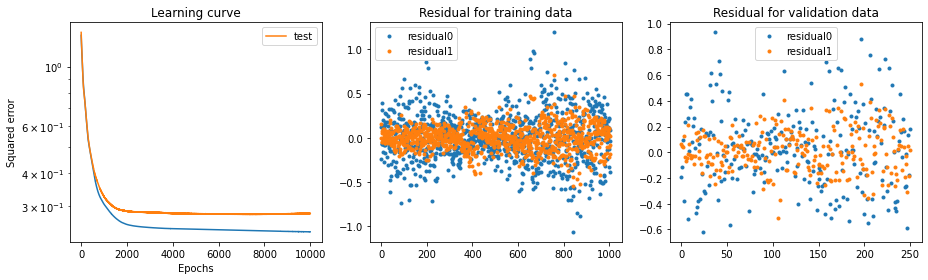

final train error: 0.24119162573592953
final val error: 0.28241047850934825


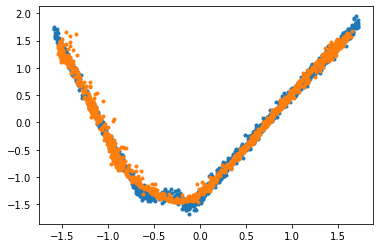

In [64]:
plot_results(best_model, input_data, val_data, train_labels, val_labels, sortidx = 1, norm = )
pred = best_model.predict(data)
plt.plot(labels[:,1],labels[:,0],".")
plt.plot(pred[:,1],pred[:,0],".")
